<a href="https://colab.research.google.com/github/auspicious0/MovieRevenue/blob/main/boxoffice_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#우선 패키지를 부착하고 출력 그래프의 크기를 설정한다.

install.packages(c("tidyverse","data.table"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(tidyverse)
library(data.table)
library(repr)

options(repr.plot.width = 7,repr.plot.height = 7)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [68]:
#https://www.kaggle.com/competitions/tmdb-box-office-prediction
#https://drive.google.com/file/d/1pdeaqGlwkZi1fmvgG6OJEyWZQvZdlvUg/view?usp=sharing
#https://drive.google.com/file/d/13QDXi_v_9di42Lw0vUAR3okJXXkacSG7/view?usp=sharing
system("gdown --id 1pdeaqGlwkZi1fmvgG6OJEyWZQvZdlvUg")
system("gdown --id 13QDXi_v_9di42Lw0vUAR3okJXXkacSG7")
system("ls",TRUE)

[1] "movie_revenue_test.csv"  "movie_revenue_train.csv"
[3] "sample_data"

파일이 정확하게 읽혔습니다.

In [83]:
mr <- bind_rows(fread("movie_revenue_test.csv",encoding = "UTF-8") %>% as_tibble(),fread("movie_revenue_train.csv",encoding = "UTF-8")%>%as_tibble())#move_revenue
mr %>% show()
str(mr)
summary(mr)

# A tibble: 7,398 × 23
      id belongs_to_collection  budget genres homepage imdb_id original_language
   <int> <chr>                   <int> <chr>  <chr>    <chr>   <chr>            
 1  3001 "[{'id': 34055, 'name… 0      [{'id… "http:/… tt1226… ja               
 2  3002 ""                     8.80e4 [{'id… ""       tt0051… en               
 3  3003 ""                     0      [{'id… ""       tt0118… en               
 4  3004 ""                     6.80e6 [{'id… "http:/… tt1255… fr               
 5  3005 ""                     2   e6 [{'id… ""       tt0418… en               
 6  3006 ""                     0      [{'id… ""       tt0120… en               
 7  3007 ""                     0      [{'id… ""       tt1517… de               
 8  3008 ""                     3   e7 [{'id… "http:/… tt0220… en               
 9  3009 ""                     1.65e7 [{'id… "http:/… tt0416… en               
10  3010 "[{'id': 10194, 'name… 9   e7 [{'id… "http:/… tt0120… en               
# ℹ 7

       id       belongs_to_collection     budget            genres         
 Min.   :   1   Length:7398           Min.   :0.00e+00   Length:7398       
 1st Qu.:1850   Class :character      1st Qu.:0.00e+00   Class :character  
 Median :3700   Mode  :character      Median :7.50e+06   Mode  :character  
 Mean   :3700                         Mean   :2.26e+07                     
 3rd Qu.:5549                         3rd Qu.:2.80e+07                     
 Max.   :7398                         Max.   :3.80e+08                     
                                                                           
   homepage           imdb_id          original_language  original_title    
 Length:7398        Length:7398        Length:7398        Length:7398       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
       

몇가지 문제가 발생하였습니다.

1. 결측값이 너무 많습니다. 따라서 결측값 처리에 관한 합리적인 방법이 필요합니다. 결측값을 모두 omit해버리면 제대로 된 모델링이 되지 않을 수 있습니다.

2. 결측값인데 결측값으로 인식되지 않는 값이 많습니다. "", "0" '[]' 등의 값이 결측 데이터로 인식되지 않습니다.

따라서 추가적인 조치를 진행하겠습니다.

In [84]:
# "0"을 na.strings에서 제외하고 데이터 읽기
mr_test <- fread("movie_revenue_test.csv", encoding = "UTF-8", na.strings = c("", "#N/A", "[]")) %>% as_tibble()
mr_train <- fread("movie_revenue_train.csv", encoding = "UTF-8", na.strings = c("", "#N/A", "[]")) %>% as_tibble()

# "0" 값을 NA로 대체
mr_test[mr_test == 0] <- NA
mr_train[mr_train == 0] <- NA

mr <- bind_rows(mr_test, mr_train)
str(mr)
summary(mr)


tibble [7,398 × 23] (S3: tbl_df/tbl/data.frame)
 $ id                   : int [1:7398] 3001 3002 3003 3004 3005 3006 3007 3008 3009 3010 ...
 $ belongs_to_collection: chr [1:7398] "[{'id': 34055, 'name': 'Pokémon Collection', 'poster_path': '/j5te0YNZAMXDBnsqTUDKIBEt8iu.jpg', 'backdrop_path'"| __truncated__ NA NA NA ...
 $ budget               : int [1:7398] NA 88000 NA 6800000 2000000 NA NA 30000000 16500000 90000000 ...
 $ genres               : chr [1:7398] "[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}, {'id': 14, "| __truncated__ "[{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}]" "[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]" "[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'name': 'War'}, {'id': 9648, 'name': 'Mystery'}]" ...
 $ homepage             : chr [1:7398] "http://www.pokemon.com/us/movies/movie-pokemon-the-rise-of-darkrai-2008/" NA NA "http://www.sonyclassics.com/incendies/" ...
 $

       id       belongs_to_collection     budget             genres         
 Min.   :   1   Length:7398           Min.   :        1   Length:7398       
 1st Qu.:1850   Class :character      1st Qu.:  5053316   Class :character  
 Median :3700   Mode  :character      Median : 17000000   Mode  :character  
 Mean   :3700                         Mean   : 31108016                     
 3rd Qu.:5549                         3rd Qu.: 40000000                     
 Max.   :7398                         Max.   :380000000                     
                                      NA's   :2023                          
   homepage           imdb_id          original_language  original_title    
 Length:7398        Length:7398        Length:7398        Length:7398       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            

이제 결측값은 모두 인식했습니다. 이제 할 일은

1. 제가 쓸 데이터 변수를 선택합니다.

2. 그 변수의 결측값을 어떻게 처리할지 생각합니다.

따라서 일단 결측값에 관한 처리를 뒤로 미뤄두고

변수의 특징을 면밀히 살피겠습니다.


In [85]:
mr$original_language%>%unique()
mr$status%>%unique()


[1] "ja" "en" "fr" "de" "he" "hi" "ru" "ka" "zh" "th" "it" "es" "bn" "sv" "ko"
[16] "sr" "da" "ta" "cs" "cn" "ro" "ca" "no" "nl" "te" "tr" "bm" "ml" "pt" "af"
[31] "fi" "ur" "el" "id" "xx" "pl" "kn" "is" "hu" "fa" "mr" "ar" "nb" "vi"

[1] "Released"        "Rumored"         "Post Production" NA

original_language는 factor형으로 부적합합니다.
status 형은 factor형으로 적합합니다.

In [86]:
mr$genres%>%unique()


[1] "[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}]"                                                                                                                                    
   [2] "[{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}]"                                                                                                                                                                                                
   [3] "[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]"                                                                                                                                                                                                      
   [4] "[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'name': 'War'}, {'id': 9648, 'name': 'Mystery'}]"                                                                                                                                                                          
   [5] "[{'id': 36, 'name': 'History'}, {'id': 99, 'name': 'Documentary'}]"                                                                                                                                                                                                    
   [6] "[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]"                                                                                                                                                                                                           
   [7] "[{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]"                                                                                                                                                                         
   [8] "[{'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}]"                                                                                                                                                                                                    
   [9] "[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]"                                                                                                                                                                                                       
  [10] "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"                                                                                                                                                                      
  [11] "[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'name': 'Horror'}, {'id': 35, 'name': 'Comedy'}]"                                                                                                                                                                          
  [12] "[{'id': 18, 'name': 'Drama'}]"                                                                                                                                                                                                                                         
  [13] "[{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}]"                                                                                                                                                                                                          
  [14] "[{'id': 12, 'name': 'Adventure'}, {'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]"                                                                                                                                        
  [15] "[{'id': 878, 'name': 'Science Fiction'}, {'id': 35, 'name': 'Comedy'}, {'id': 12, 'name': 'Adventure'}]"                                                                                   

살펴본 결과 쓸 변수는 budget, genres, original_language, popularity, runtime, status이란 설명변수에 따른 revenue를 알아보려 합니다.

1. chr형 변수 genres, original_language, status는 factor형으로 변환하겠습니다.

2. 이중 정수형 변수 budget, popularity, revenue, runtime은 결측값 처리 후 이상값을 처리하겠습니다.


In [87]:
mr <- select(mr,budget,genres,original_language,popularity,runtime,revenue,status)%>%
  mutate_at(c("genres","original_language","status"),factor)

In [88]:
mr %>% str()
mr %>% show()

tibble [7,398 × 7] (S3: tbl_df/tbl/data.frame)
 $ budget           : int [1:7398] NA 88000 NA 6800000 2000000 NA NA 30000000 16500000 90000000 ...
 $ genres           : Factor w/ 1520 levels "[{'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}, {'id': 10752, 'name': 'War'}]",..: 211 767 1084 547 1235 1157 44 461 529 497 ...
 $ original_language: Factor w/ 44 levels "af","ar","bm",..: 22 11 11 15 11 11 9 11 11 11 ...
 $ popularity       : num [1:7398] 3.85 3.56 8.09 8.6 3.22 ...
 $ runtime          : int [1:7398] 90 65 100 130 92 121 119 77 120 92 ...
 $ revenue          : int [1:7398] NA NA NA NA NA NA NA NA NA NA ...
 $ status           : Factor w/ 3 levels "Post Production",..: 2 2 2 2 2 2 2 2 2 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 
# A tibble: 7,398 × 7
     budget genres           original_language popularity runtime revenue status
      <int> <fct>            <fct>                  <dbl>   <int>   <int> <fct> 
 1       NA [{'id': 12, 'na… ja           

mr$genres가 (id) (genres) 각각 key value값으로 설정되어 있어 1520개의 factor형 변수가 발생하였습니다. 이를 두번째 인덱스의 value만을 변수에 저장하는 방법으로 해결해 보겠습니다.

In [89]:
# 'genres' 열에서 "{'id': xxx, 'name': 'yyy'}" 중 'yyy' 부분 추출
mr$genres <- gsub(".*'name':\\s*'([^']*)'.*", "\\1", as.character(mr$genres))

# 결과 출력
print(mr$genres)

   [1] "Fantasy"         "Science Fiction" "Romance"         "Mystery"        
   [5] "Documentary"     "Drama"           "Comedy"          "Family"         
   [9] "Romance"         "Family"          "Comedy"          "Drama"          
  [13] "Comedy"          "Romance"         "Romance"         "Drama"          
  [17] "Adventure"       "Mystery"         "Music"           "Thriller"       
  [21] "Thriller"        "Comedy"          "Music"           "Thriller"       
  [25] "Thriller"        "Thriller"        "Family"          "Drama"          
  [29] "Romance"         "Western"         "Comedy"          "Drama"          
  [33] "Animation"       "Documentary"     "Romance"         "Thriller"       
  [37] "Family"          "Thriller"        "Family"          "War"            
  [41] "Drama"           "Thriller"        "Comedy"          "Comedy"         
  [45] "Science Fiction" "Thriller"        "Thriller"        "Thriller"       
  [49] "Drama"           "Music"           "Thriller

In [90]:
mr %>% str()

tibble [7,398 × 7] (S3: tbl_df/tbl/data.frame)
 $ budget           : int [1:7398] NA 88000 NA 6800000 2000000 NA NA 30000000 16500000 90000000 ...
 $ genres           : chr [1:7398] "Fantasy" "Science Fiction" "Romance" "Mystery" ...
 $ original_language: Factor w/ 44 levels "af","ar","bm",..: 22 11 11 15 11 11 9 11 11 11 ...
 $ popularity       : num [1:7398] 3.85 3.56 8.09 8.6 3.22 ...
 $ runtime          : int [1:7398] 90 65 100 130 92 121 119 77 120 92 ...
 $ revenue          : int [1:7398] NA NA NA NA NA NA NA NA NA NA ...
 $ status           : Factor w/ 3 levels "Post Production",..: 2 2 2 2 2 2 2 2 2 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


다시 genres 를 factor형 변수로 변환하겠습니다.

In [91]:
mr <- mr %>%
  mutate_at(c("genres"),factor)

In [92]:
mr %>% str()
mr %>% summary()

tibble [7,398 × 7] (S3: tbl_df/tbl/data.frame)
 $ budget           : int [1:7398] NA 88000 NA 6800000 2000000 NA NA 30000000 16500000 90000000 ...
 $ genres           : Factor w/ 19 levels "Action","Adventure",..: 9 16 15 14 6 7 4 8 15 8 ...
 $ original_language: Factor w/ 44 levels "af","ar","bm",..: 22 11 11 15 11 11 9 11 11 11 ...
 $ popularity       : num [1:7398] 3.85 3.56 8.09 8.6 3.22 ...
 $ runtime          : int [1:7398] 90 65 100 130 92 121 119 77 120 92 ...
 $ revenue          : int [1:7398] NA NA NA NA NA NA NA NA NA NA ...
 $ status           : Factor w/ 3 levels "Post Production",..: 2 2 2 2 2 2 2 2 2 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


     budget                      genres     original_language   popularity     
 Min.   :        1   Drama          :1336   en     :6351      Min.   :  0.000  
 1st Qu.:  5053316   Thriller       :1245   fr     : 199      1st Qu.:  3.933  
 Median : 17000000   Romance        :1070   hi     : 118      Median :  7.436  
 Mean   : 31108016   Comedy         : 868   ru     : 109      Mean   :  8.515  
 3rd Qu.: 40000000   Science Fiction: 405   es     :  95      3rd Qu.: 10.920  
 Max.   :380000000   (Other)        :2451   ja     :  90      Max.   :547.488  
 NA's   :2023        NA's           :  23   (Other): 436                       
    runtime       revenue                      status    
 Min.   : 11   Min.   :1.000e+00   Post Production:   5  
 1st Qu.: 94   1st Qu.:2.380e+06   Released       :7385  
 Median :104   Median :1.681e+07   Rumored        :   6  
 Mean   :108   Mean   :6.673e+07   NA's           :   2  
 3rd Qu.:118   3rd Qu.:6.892e+07                         
 Max.   :338

이를 통해 펙터형 변수로 변환이 완료되었습니다.

이제 결측값 및 이상값 처리를 진행하겠습니다.

결측값이 많은 budget, revenue 결측값은 너무 많기 때문에 중간값으로 정리하고 나머지 결측값은 삭제하겠습니다.

그 후 정수형 데이터는 이상값 처리를 진행하겠습니다.


In [15]:
install.packages("Hmisc")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’




In [93]:
library(Hmisc)
mr$budget <- impute(mr$budget, median) #mean, median, 특정숫자
mr %>% show()

# A tibble: 7,398 × 7
   budget   genres          original_language popularity runtime revenue status 
   <impute> <fct>           <fct>                  <dbl>   <int>   <int> <fct>  
 1 17000000 Fantasy         ja                      3.85      90      NA Releas…
 2    88000 Science Fiction en                      3.56      65      NA Releas…
 3 17000000 Romance         en                      8.09     100      NA Releas…
 4  6800000 Mystery         fr                      8.60     130      NA Releas…
 5  2000000 Documentary     en                      3.22      92      NA Releas…
 6 17000000 Drama           en                      8.68     121      NA Releas…
 7 17000000 Comedy          de                      4.90     119      NA Releas…
 8 30000000 Family          en                      7.02      77      NA Releas…
 9 16500000 Romance         en                      7.83     120      NA Releas…
10 90000000 Family          en                     17.5       92      NA Releas…
# ℹ 7,

In [97]:
#mr$revenue <- impute(mr$revenue, median) #mean, median, 특정숫자
#아무래도 revenue 는 반응변수 종속변수이다 보니 같은 숫자가 너무 많으면
#차질이 발생할 것으로 예상됩니다. 따라서
#na.omit으로 삭제한 후 진행하겠습니다.
mr$revenue <- mr$revenue%>% na.omit()


In [95]:
mr %>% show()
table(is.na(mr))

# A tibble: 7,398 × 7
   budget   genres          original_language popularity runtime revenue status 
   <impute> <fct>           <fct>                  <dbl>   <int>   <int> <fct>  
 1 17000000 Fantasy         ja                      3.85      90      NA Releas…
 2    88000 Science Fiction en                      3.56      65      NA Releas…
 3 17000000 Romance         en                      8.09     100      NA Releas…
 4  6800000 Mystery         fr                      8.60     130      NA Releas…
 5  2000000 Documentary     en                      3.22      92      NA Releas…
 6 17000000 Drama           en                      8.68     121      NA Releas…
 7 17000000 Comedy          de                      4.90     119      NA Releas…
 8 30000000 Family          en                      7.02      77      NA Releas…
 9 16500000 Romance         en                      7.83     120      NA Releas…
10 90000000 Family          en                     17.5       92      NA Releas…
# ℹ 7,


FALSE  TRUE 
47336  4450 

52개의 결측값은 삭제하도록 하겠습니다.
또한 revenue 와 budget 값의 형을 int형으로 변환하겠습니다.


In [96]:
mr <- na.omit(mr)
table(is.na(mr))
mr %>% str()



FALSE 
20853 

tibble [2,979 × 7] (S3: tbl_df/tbl/data.frame)
 $ budget           : 'impute' Named int [1:2979] 14000000 40000000 3300000 1200000 17000000 8000000 14000000 17000000 17000000 6000000 ...
  ..- attr(*, "names")= chr [1:2979] "4399" "4400" "4401" "4402" ...
  ..- attr(*, "imputed")= int [1:803] 5 8 9 12 18 23 24 25 26 32 ...
 $ genres           : Factor w/ 19 levels "Action","Adventure",..: 4 15 7 7 17 8 17 6 2 13 ...
 $ original_language: Factor w/ 44 levels "af","ar","bm",..: 11 11 11 17 25 11 11 11 11 11 ...
 $ popularity       : num [1:2979] 6.58 8.25 64.3 3.17 1.15 ...
 $ runtime          : int [1:2979] 93 113 105 122 118 83 92 84 100 91 ...
 $ revenue          : int [1:2979] 12314651 95149435 13092000 16000000 3923970 3261638 85446075 2586511 34327391 18750246 ...
 $ status           : Factor w/ 3 levels "Post Production",..: 2 2 2 2 2 2 2 2 2 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "na.action")= 'omit' Named int [1:4419] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(

결측값 처리를 완료하였습니다. 이상값 처리를 진행하겠습니다.


FALSE 
20853 

Warning message in x[floor(d)] + x[ceiling(d)]:
“NAs produced by integer overflow”



 803 values imputed to 17000000 


 803 values imputed to 17000000 




FALSE  TRUE 
20045   808 


FALSE 
17059 

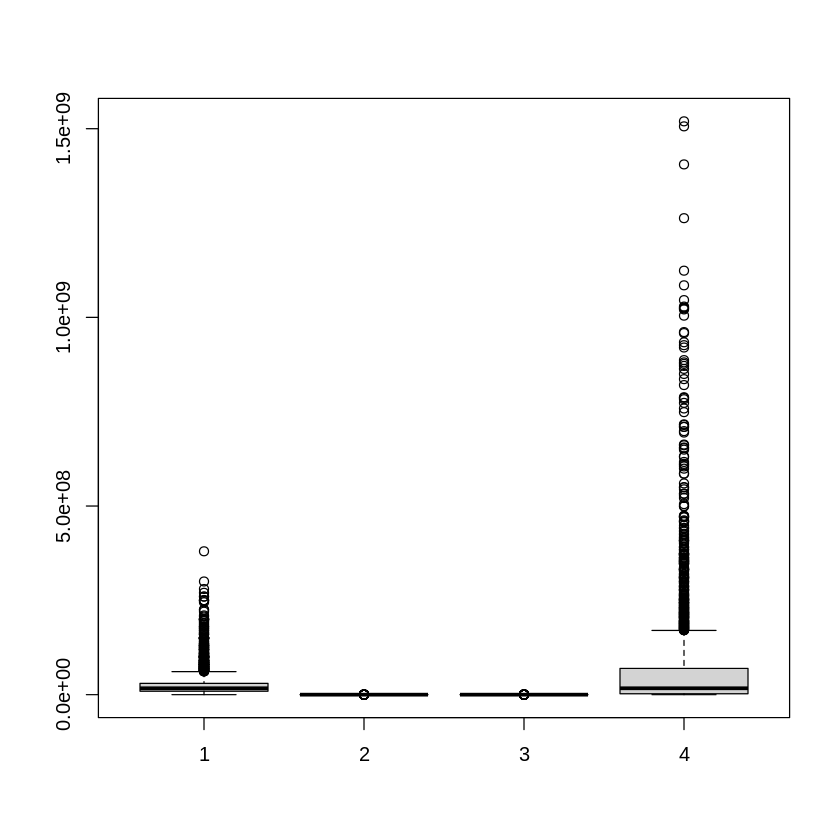

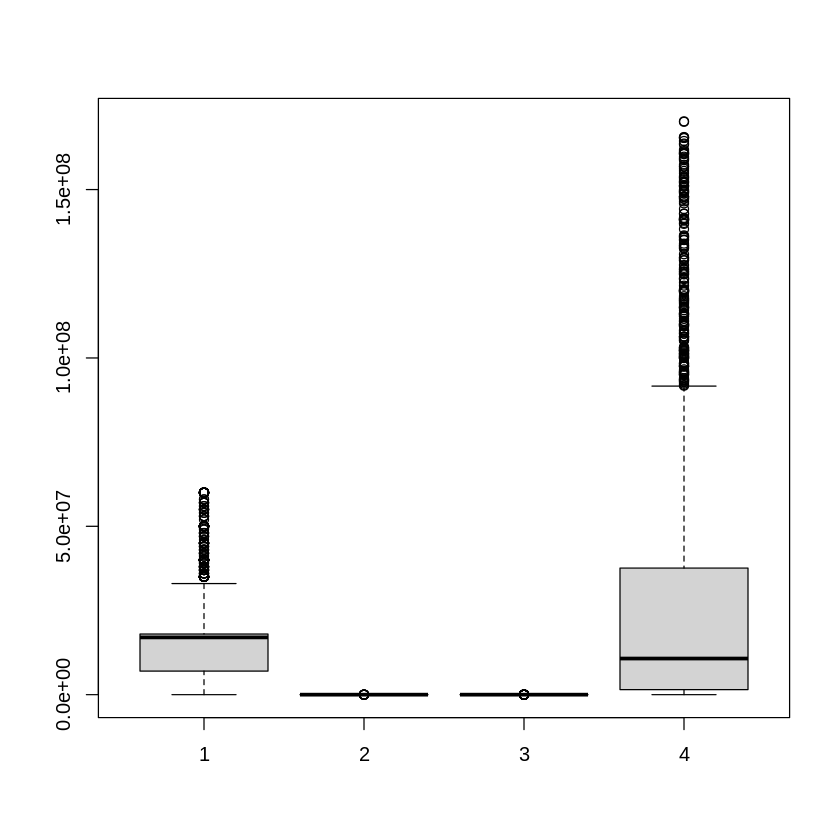

In [98]:
# 이상치 및 결측값 처리 함수

calculate_outliers <- function(data, column_name) {
  iqr_value <- IQR(data[[column_name]])
  upper_limit <- summary(data[[column_name]])[5] + 1.5 * iqr_value
  lower_limit <- summary(data[[column_name]])[2] - 1.5 * iqr_value

  data[[column_name]] <- ifelse(data[[column_name]] < lower_limit | data[[column_name]] > upper_limit, NA, data[[column_name]])

  return(data)
}
table(is.na(mr))
boxplot(mr$budget,mr$popularity,mr$runtime,mr$revenue)
# 이상치 및 결측값 처리 및 결과에 대한 상자그림 그리기
mr <- calculate_outliers(mr, "budget")
mr <- calculate_outliers(mr, "popularity")
mr <- calculate_outliers(mr, "runtime")
mr <- calculate_outliers(mr, "revenue")

table(is.na(mr))
mr <- na.omit(mr)
table(is.na(mr))
boxplot(mr$budget,mr$popularity,mr$runtime,mr$revenue)#char형 변수를 제외하고 정수형 변수만을  boxplot을 그려보겠습니다.


이상값 처리를 완료하였습니다.
우선 mr 데이터를 9:1로 학습 테스트 데이터로 분라하겠습니다.

무작위로 데이터를 분리하지 않고 반응변수를 중심으로 7:3로 나누기 위해 caret::createDataPartition을 사용하겠습니다.
하지만 너무 데이터 양이 많아서 프로젝트가 진행되지 않습니다.

따라서 6:4로 나눠보겠습니다.

In [21]:
install.packages("caret")
library(caret)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [99]:

index <- caret::createDataPartition(y = mr$revenue, p = 0.8, list = FALSE)
train <- mr[index, ]
test <- mr[-index, ]
model_bagging <-ipred::bagging(revenue ~ ., data = train, nbagg = 100)

이제 bagging 및 Random Forest로 데이터를 분석해 보겠습니다.

우선 bagging 모델을 생성하고 bagging 모델의 예측력을 확인해 보겠습니다.

In [23]:
install.packages(c("ipred","randomForest"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [100]:

summary(model_bagging)

       Length Class      Mode   
y      1952   -none-     numeric
X         6   data.frame list   
mtrees  100   -none-     list   
OOB       1   -none-     logical
comb      1   -none-     logical
call      4   -none-     call   

데이터 개수가 너무 많아 시간이 많이 소요 됩니다.

 따라서 nbagg을 5회만 수행하겠습니다. 예측을 수행해 보겠습니다.

 3회 수행하는 것이 적당했던 것 같습니다. 30분째 되지 않습니다.

 3회도 마찬가지 입니다...

 뭐가 문제인지 감이 잡히지 않습니다.

-> na.omit으로 revenue 변수의 결측값을 삭제하니 잘 수행되었습니다.

In [101]:
predict_value_bagging <- predict(model_bagging, test, type = "class")%>%
  tibble(predict_value_bagging = .)
head(predict_value_bagging)
predict_check_bagging <- test %>% select(revenue)%>%dplyr::bind_cols(.,predict_value_bagging)
predict_check_bagging

predict_value_bagging
<dbl>
7733128
27221332
7733128
7733128
7733128
26386937


revenue,predict_value_bagging
<int>,<dbl>
3261638,7733128
85446075,27221332
1234254,7733128
17011,7733128
13835130,7733128
24362772,26386937
4300000,7733128
120000000,82011949
11000000,7733128


예측값이 우수하지 않아 보입니다. 따라서 회귀 분석은 여기서 종료하고

revenue의 평균값 미만 데이터는 0
revenue의 평균값 이상 데이터는 1로
변환 후 factor형으로 변환한 후
다시 bagging, randomforest 분석 후 시각화하는 과정을 보이겠습니다.


In [102]:
# revenue 열의 평균값 계산
revenue_mean <- mean(mr$revenue, na.rm = TRUE)

# 변환: revenue 열 값이 revenue 평균값 미만인 경우 0, 이상인 경우 1로 변경
mr$revenue <- ifelse(mr$revenue < revenue_mean, 0, 1)

# factor 데이터 유형으로 변환
mr$revenue <- factor(mr$revenue)

In [103]:
mr$revenue%>% str()

 Factor w/ 2 levels "0","1": 1 2 1 1 1 2 1 2 1 2 ...


변화가 있었으니 다시 데이터를 나누고 model_bagging을 생성하겠습니다.

In [104]:
index <- caret::createDataPartition(y = mr$revenue, p = 0.8, list = FALSE)
train <- mr[index, ]
test <- mr[-index, ]
model_bagging <-ipred::bagging(revenue ~ ., data = train, nbagg = 100)

모델을 사용하여 test 데이터로 예측을 수행한 후 예측값을 저장하고 실제 데이터와 대조하여 확인해 보겠습니다.

In [105]:
predict_value_bagging <- predict(model_bagging, test, type = "class") %>% tibble(predict_value_bagging = .)
predict_check_bagging <- test %>% select(revenue) %>% dplyr::bind_cols(., predict_value_bagging)
head(predict_check_bagging)

revenue,predict_value_bagging
<fct>,<fct>
1,1
1,1
0,0
1,1
0,0
0,0


예측된 결과 어느 정도 예측을 수행한 것으로 확인할 수 있습니다. confusionMatrix를 활용하여 성능지표를 확인하겠습니다.

In [106]:
cm <- caret::confusionMatrix(predict_check_bagging$predict_value_bagging,test$revenue)
cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 292  73
         1  42  80
                                          
               Accuracy : 0.7639          
                 95% CI : (0.7236, 0.8009)
    No Information Rate : 0.6858          
    P-Value [Acc > NIR] : 8.855e-05       
                                          
                  Kappa : 0.4202          
                                          
 Mcnemar's Test P-Value : 0.00515         
                                          
            Sensitivity : 0.8743          
            Specificity : 0.5229          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.6557          
             Prevalence : 0.6858          
         Detection Rate : 0.5996          
   Detection Prevalence : 0.7495          
      Balanced Accuracy : 0.6986          
                                          
       'Positive' Class : 0               
                              

76퍼센트 정도의 정확성을 가진 것을 확인할 수 있습니다.

이제 train 데이터로 RandomForest 모델을 만들어 보겠습니다.

In [108]:
library(randomForest)
model_rf <- randomForest(revenue ~ ., data = train, na.action = na.omit, importance = T, mtry = 7, ntree = 1000)
model_rf

Warning message in randomForest.default(m, y, ...):
“invalid mtry: reset to within valid range”



Call:
 randomForest(formula = revenue ~ ., data = train, importance = T,      mtry = 7, ntree = 1000, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 6

        OOB estimate of  error rate: 24.21%
Confusion matrix:
     0   1 class.error
0 1118 220   0.1644245
1  252 360   0.4117647

만든 랜덤포레스트 모델로 예측을 수행한 후 실제 값과 결과를 비교해 보겠습니다.

In [109]:
predict_value_rf <- predict(model_rf, test, type = "class") %>% tibble(predict_value_rf = .)
predict_check_rf <- test %>% select(revenue) %>% dplyr::bind_cols(., predict_value_rf)
head(predict_check_rf)

revenue,predict_value_rf
<fct>,<fct>
1,1
1,1
0,0
1,1
0,0
0,0


예측을 잘 수행한 것을 확인할 수 있습니다.

이제 예측값을 저장한 데이터와 실제 데이터 사이의 confusionMatrix를 생성한 후 성능지표를 확인해 보겠습니다.

In [110]:
cm <- caret::confusionMatrix(predict_check_rf$predict_value_rf,test$revenue)
cm

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 283  67
         1  51  86
                                          
               Accuracy : 0.7577          
                 95% CI : (0.7171, 0.7951)
    No Information Rate : 0.6858          
    P-Value [Acc > NIR] : 0.0002898       
                                          
                  Kappa : 0.4213          
                                          
 Mcnemar's Test P-Value : 0.1673214       
                                          
            Sensitivity : 0.8473          
            Specificity : 0.5621          
         Pos Pred Value : 0.8086          
         Neg Pred Value : 0.6277          
             Prevalence : 0.6858          
         Detection Rate : 0.5811          
   Detection Prevalence : 0.7187          
      Balanced Accuracy : 0.7047          
                                          
       'Positive' Class : 0               
                              

이전 보다 1프로 낮은 정확도를 보이는 것을 확인할 수 있습니다. (75프로)

모델에서 변수의 중요도를 그림으로 나타내 보겠습니다.

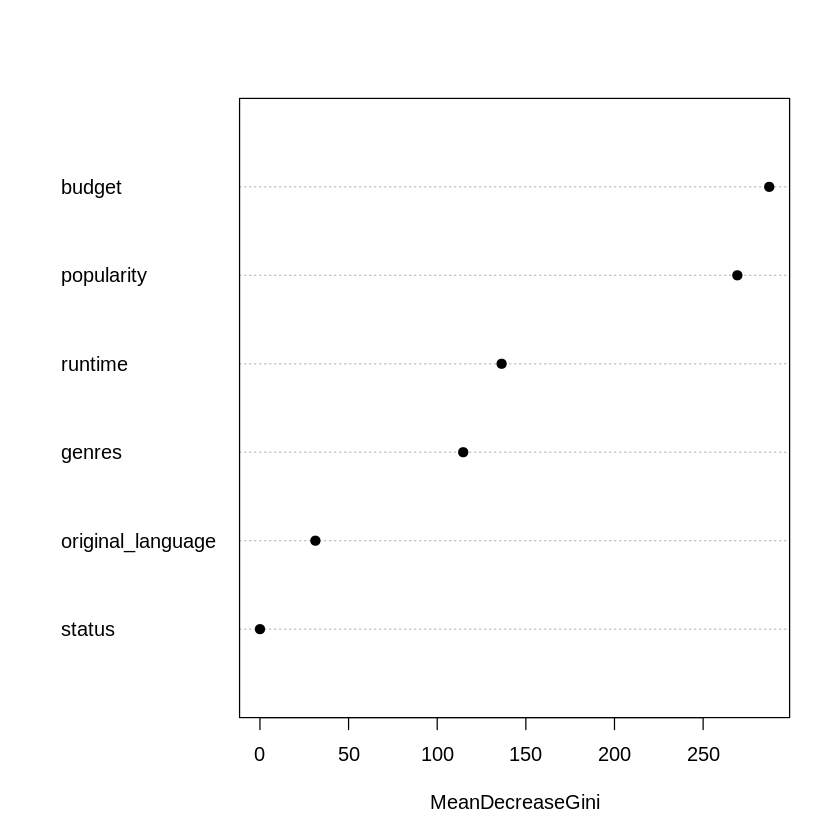

In [112]:
varImpPlot(model_rf, type = 2, pch = 19, col = 1, cex = 1, main = "")

수익(revenue)에 가장 중요한 요소는 budget(예산)과 인기, 상영시간, 장르 순으로 이루어진 것을 확인할 수 있습니다.